# First-Order Systems

## What are first-order systems?

Scalar first-order linear systems are the simplest type of dynamical systems that can be described by a first-order ordinary differential equation

$$
\frac{dx(t)}{dt} = A x(t) + B u(t)
$$

where $A \in \mathbb{R}$ and $B \in \mathbb{R}$. Here, $x(t)$ is the state of the system at time $t$ and $u(t)$ is the input to the system at time $t$.
Let's consider that the system is initialized at the initial condition $x_{0} \in \mathbb{R}$.


> Wonder why: What makes a differential equation an __ordinary__ differential equation?

##Example: Adaptive Cruise Control

In adaptive cruise control, we want to regulate the vehicle speed by applying engine torque. To keep things simple, we will ignore road slope and other disturbances for now, and focus only on how torque changes the speed.

This gives us a very clean first-order system: the car speeds up when torque is applied, and it naturally slows down due to drag when no torque is applied.


From Newton's law, the vehicle dynamics can be written as

$$
m \dot v(t) = k_u u(t) - b v(t),
$$

where
* $v(t)$ is the vehicle speed,
* $u(t)$ is the engine torque input,
* $m$ is the vehicle mass,
* $k_u$ converts torque to driving force,
* $b$ is the drag coefficient.

Dividing through by $m$ gives

$$
\dot v(t) = -\frac{b}{m} v(t) + \frac{k_u}{m} u(t).
$$

By defining the state as $x(t) = v(t)$, the dynamics can be written in state-space form as

$$
\dot x(t) = A x(t) + B u(t)
$$

with parameters

$$
A = -\frac{b}{m} \text{ and } B = \frac{k_u}{m}.
$$

ADD SIMULATIONS
SHOW MULTIPLE INITIAL CONDITIONS

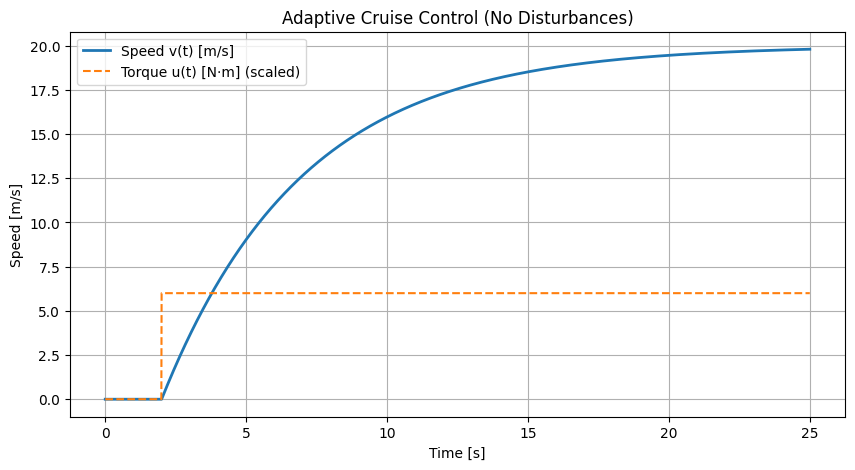

In [2]:
# @title Adaptive Cruise Control: Simple First-Order Model (No Disturbances)

import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 1500.0    # mass [kg]
b = 300.0     # drag coefficient [N*s/m]
k_u = 50.0    # torque-to-force gain [N per N·m]

# Simulation time
t_final = 25.0
dt = 0.01
t = np.arange(0.0, t_final + dt, dt)

# Input: engine torque profile
def torque_input(t):
    # Step in torque at t = 2 s
    return 120.0 * (t >= 2.0)

# Dynamics: m dv/dt = k_u u - b v
def simulate(t, v0=0.0):
    u = torque_input(t)
    v = np.zeros_like(t)
    v[0] = v0
    a = -b/m
    bu = k_u/m
    for k in range(len(t)-1):
        dv = a*v[k] + bu*u[k]
        v[k+1] = v[k] + dt*dv
    return v, u

# Run simulation
v, u = simulate(t)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(t, v, label="Speed v(t) [m/s]", linewidth=2)
plt.plot(t, u/20.0, "--", label="Torque u(t) [N·m] (scaled)")  # scaled for visibility
plt.title("Adaptive Cruise Control (No Disturbances)")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.legend()
plt.grid(True)
plt.show()

In reality, a car doesn't just respond to torque. Road slope and other forces (like wind drag or rolling resistance) act as disturbances. These affect the speed even if the driver (or controller) applies the same torque.

To capture this, we add two disturbance terms:
* Road inclination $\theta(t)$, which creates an uphill or downhill force,
* External disturbance $w(t)$, which represents extra forces such as wind gusts.

### Vehicle Dynamics

The full longitudinal dynamics are

$$
m \dot v(t) = k_u u(t) - b v(t) - m g \theta(t) + w(t),
$$

where
* $- m g \theta(t)$ models the component of gravity on a slope (using $\sin \theta \approx \theta$ for small angles), and
* $w(t)$ is a lumped disturbance force.

Dividing through by $m$ gives

$$
\dot v(t) = -\frac{b}{m} v(t) + \frac{k_u}{m} u(t) - g \theta(t) + \frac{1}{m} w(t).
$$

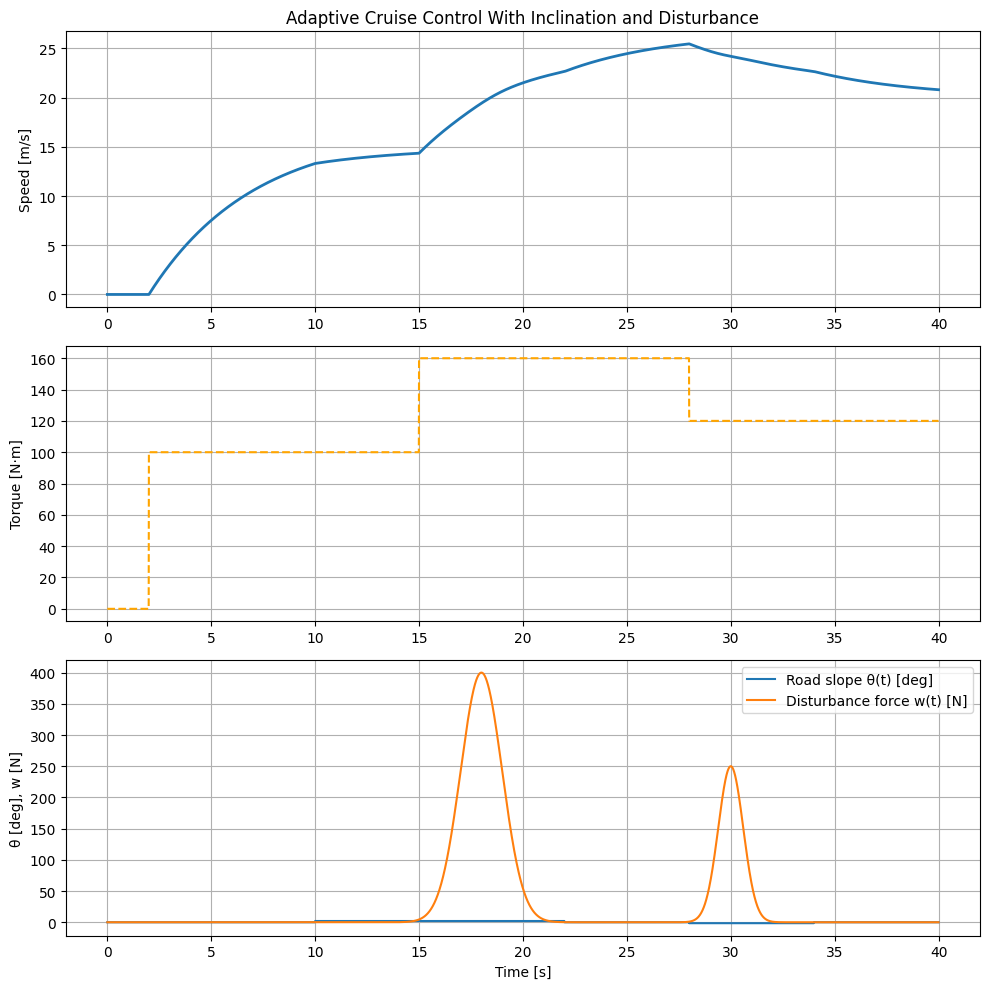

In [1]:
# @title Adaptive Cruise Control: First-Order Model With Disturbances

import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 1500.0
b = 300.0
k_u = 50.0
g = 9.81

# Simulation time
t_final = 40.0
dt = 0.01
t = np.arange(0.0, t_final + dt, dt)

# Inputs
def torque_input(t):
    u = np.zeros_like(t)
    u += 100.0 * (t >= 2.0)
    u += 60.0  * (t >= 15.0)
    u -= 40.0  * (t >= 28.0)
    return u

def road_inclination(t):
    theta = np.zeros_like(t)
    theta += (2*np.pi/180.0) * ((t >= 10) & (t < 22))   # +2 deg uphill
    theta += (-1.5*np.pi/180.0) * ((t >= 28) & (t < 34)) # -1.5 deg downhill
    return theta

def disturbance_force(t):
    w = np.zeros_like(t)
    w += 400.0 * np.exp(-0.5*((t-18.0)/1.0)**2)  # gust at 18s
    w += 250.0 * np.exp(-0.5*((t-30.0)/0.6)**2)  # gust at 30s
    return w

# Dynamics: m dv/dt = k_u u - b v - m g theta + w
def simulate(t, v0=0.0):
    u = torque_input(t)
    theta = road_inclination(t)
    w = disturbance_force(t)
    v = np.zeros_like(t)
    v[0] = v0
    for k in range(len(t)-1):
        dv = (-b/m)*v[k] + (k_u/m)*u[k] - g*theta[k] + (1/m)*w[k]
        v[k+1] = v[k] + dt*dv
    return v, u, theta, w

# Run simulation
v, u, theta, w = simulate(t)

# Plot results
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.plot(t, v, label="Speed v(t) [m/s]", linewidth=2)
plt.title("Adaptive Cruise Control With Inclination and Disturbance")
plt.ylabel("Speed [m/s]")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, u, "--", label="Torque u(t) [N·m]", color="orange")
plt.ylabel("Torque [N·m]")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, theta*180/np.pi, label="Road slope θ(t) [deg]")
plt.plot(t, w, label="Disturbance force w(t) [N]")
plt.xlabel("Time [s]")
plt.ylabel("θ [deg], w [N]")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()